In [1]:
import numpy as np
import sempler
import sempler.generators
import src.utils as utils
import src.metrics as metrics

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec

import pickle
import os

import time

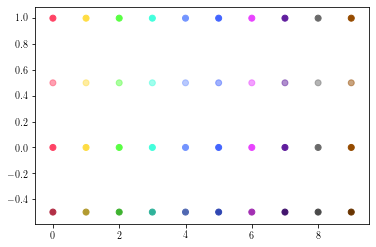

In [2]:
# Set tex formatting for plots
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.serif"] = ["Computer Modern Roman"]

# Set legend size
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('medium')

# Colors
def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

cmap = matplotlib.cm.get_cmap('tab20')
# Colorblind safe palettes
base = ['#d73027', '#f46d43', '#fdae61', '#fee090', '#020202', '#abd9e9', '#74add1', '#4575b4']
#base = ['#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac']
#base = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#c7eae5', '#80cdc1', '#35978f', '#01665e']
# Rainbow palette
base = ["#ff4365", "#ffdd43", "#59ff43", "#43ffdd", "#7395ff", "#4365ff", "#e943ff", "#601e9e", "#6a6a6a", "#964b00"]#np.array([cmap(i) for i in range(2,20)])
plt.scatter(np.arange(len(base)), np.ones(len(base)), c = base)
#base = [base[i] for i in [0,1,3]]
colors = to_rgb(base)
colorsa = to_rgb(base, a=0.5)
colorsb = to_rgb(base, b=0.7)
plt.scatter(np.arange(len(colors)), np.zeros(len(colors)), c = colors)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*0.5, c = colorsa)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*-0.5, c = colorsb)

## Load results

In [3]:
directory_real = "sachs_experiments/dataset_1661368400_sachs_sachs_2005_normalized:True/"
directory_drf = "sachs_experiments/dataset_1661774872_runs:10_seed:42_tag:sachs_2005_normalized_type:drf_standardize:0_n:None/"

In [4]:
def load_results(directory, method, lambdas_idx=2):
    args, results = utils.read_pickle(directory + utils.compiled_results_filename(method))
    ground_truth, metrics = utils.read_pickle(directory + "metrics_%s.pickle" % method)
    return args, results, ground_truth, metrics, args[lambdas_idx]

### Load and plot UT-IGSP results for each choice of observational environment

In [5]:
env_names = { 1: "cd3cd28",
2: "cd3cd28icam2",
3: "cd3cd28+aktinhib",
4: "cd3cd28+g0076",
5: "cd3cd28+psitect",
6: "cd3cd28+u0126",
7: "cd3cd28+ly",
8: "pma",
9: "b2camp",}

In [6]:
def extract_metrics(directory, filename, num):
    all_metrics, all_alphas = [], []
    for i in range(num):
        _, _, _, m, a = load_results(directory, filename % i,lambdas_idx=1)
        all_metrics.append(m)
        all_alphas.append(a)
    t1e = [np.nanmean(m[metrics.type_1_structc], axis=(0,4))[:,0] for m in all_metrics]
    t2e = [np.nanmean(m[metrics.type_2_structc], axis=(0,4))[:,0] for m in all_metrics]
    success = [np.nanmean(m[metrics.success_metric], axis=(0,4))[:,0] for m in all_metrics]
    return t1e, t2e, all_alphas, success

## Figures 8 and 9: UT-IGSP with different observational environments

#### For the real dataset

In [7]:
t1e_gauss, t2e_gauss, alphas_gauss, _ = extract_metrics(directory_real, 'ut_igsp_gauss_obs:%d', 9)
t1e_hsic, t2e_hsic, alphas_hsic, _ = extract_metrics(directory_real, 'ut_igsp_hsic_obs:%d', 9)

In [8]:
t1e_real_gauss, t2e_real_gauss, alphas_real_gauss = t1e_gauss, t2e_gauss, alphas_gauss
t1e_real_hsic, t2e_real_hsic, alphas_real_hsic = t1e_hsic, t2e_hsic, alphas_hsic

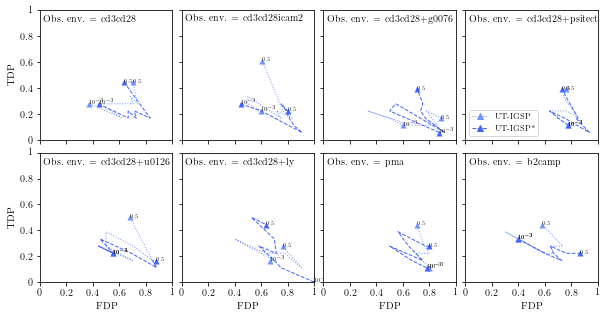

In [9]:
text = True
textsize = 5
lineopts = {'linewidth': 1}
ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
marker = {'gnies': '.',
          'gnies_rank': '.',
          'ges': '*',
          'ut_igsp': '^',
          'ut_igsp_hsic': '^',
          'jci_pc': 's',           
}
style = {'gnies': '-',
         'gnies_rank': ':',
         'ges': ':',
         'ut_igsp': ':',
         'ut_igsp_hsic': '--',
         'jci_pc': ':',
           
}
color = {'gnies': colors[0],
         'gnies_rank': colorsa[0],
         'ges': colors[1],
         'ut_igsp': colors[4],
         'ut_igsp_hsic': colors[5],
         'jci_pc': colors[2],
         
}

print_names = {'ut_igsp': 'UT-IGSP',
               'ut_igsp_hsic': 'UT-IGSP*',
               #'jci_pc': 'JCI-PC',         
}

def set_ax(ax, yticks=True, xticks=True):
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('FDP') if xticks else None
    ax.set_ylabel('TDP') if yticks else None
    ax.set_yticks(ticks)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks) if xticks else ax.set_xticklabels([])
    ax.set_yticklabels(ticks) if yticks else ax.set_yticklabels([])

def plot_metric(ax, values_x, values_y, lambdas, method, points, text, gray=False):
    c = '#aaaaaa' if gray else color[method]
    values_y = 1 - values_y
    ax.plot(values_x, values_y, color=c, linestyle=style[method], **lineopts)
    for j, l in enumerate(lambdas):
        #ax.scatter(values_x[j], values_y[j], color=color[method], marker=".", linewidth=0)
        if j==0 and text[0] is not None:
            if l <= 0.001:
                l = np.log10(l)
                fmt = "$10^{%d}$"
            else:
                fmt = "$"+text[0]+"$"
            ax.text(values_x[j], values_y[j], fmt % l, fontsize=textsize, ha="left")
        if l==lambdas[-1] and text[1] is not None:
            ax.text(values_x[j], values_y[j], ("$"+text[1]+"$") % l, fontsize=textsize, ha="left")
        if j in points:
            ax.scatter(values_x[j], values_y[j], color=c, marker=marker[method], linewidth=0)

cols = 3
d = 2.5
#gs = gridspec.GridSpec(cols, cols, wspace=0.07, hspace=0.1)
#plt.figure(figsize=(d*cols,d*cols))
gs = gridspec.GridSpec(2, 4, wspace=0.07, hspace=0.1)
plt.figure(figsize=(d*4,d*2))
ax = plt.gca()

for k,i in enumerate([j for j in range(9) if j != 2]):
    ###########################
    # PLOT REAL DATA
    plt.subplot(gs[k])
    ax = plt.gca()    
    if k == 3:
        ax0 = ax    
    # Plot UT-IGSP
    plot_metric(ax, t1e_gauss[i], t2e_gauss[i], alphas_gauss[i], 'ut_igsp', [0,len(alphas_gauss[i])-1], ["%0.2f", "%0.1f"])
    # Plot UT-IGSP*
    plot_metric(ax, t1e_hsic[i], t2e_hsic[i], alphas_hsic[i], 'ut_igsp_hsic', [0,len(alphas_hsic[i])-1], ["%0.2f", "%0.1f"])
    set_ax(ax, yticks=k % 4 == 0, xticks=k >= 4)
    ax.text(0.025,0.91,"Obs. env. = %s" % env_names[i+1])
# Build legend
method_entries = [Line2D([0], [0],
                         linewidth=1,
                         linestyle=style[method],
                         marker=marker[method],
                         color=color[method]) for method in print_names.keys()]
method_str = list(print_names.values())
ax0.legend(method_entries, #+ sample_size_entries
          method_str, # + sample_size_str
          prop={'size':8},
          loc='lower left',
        ncol=1)

filename = 'figures/figure_sachs_real_all_obs.pdf'
plt.savefig(filename, bbox_inches='tight')

#### For the semi-synthetic dataset

In [10]:
t1e_gauss, t2e_gauss, alphas_gauss, _ = extract_metrics(directory_drf, 'ut_igsp_gauss_obs:%d', 9)
t1e_hsic, t2e_hsic, alphas_hsic, _ = extract_metrics(directory_drf, 'ut_igsp_hsic_obs:%d', 9)

In [11]:
t1e_drf_gauss, t2e_drf_gauss, alphas_drf_gauss = t1e_gauss, t2e_gauss, alphas_gauss
t1e_drf_hsic, t2e_drf_hsic, alphas_drf_hsic = t1e_hsic, t2e_hsic, alphas_hsic

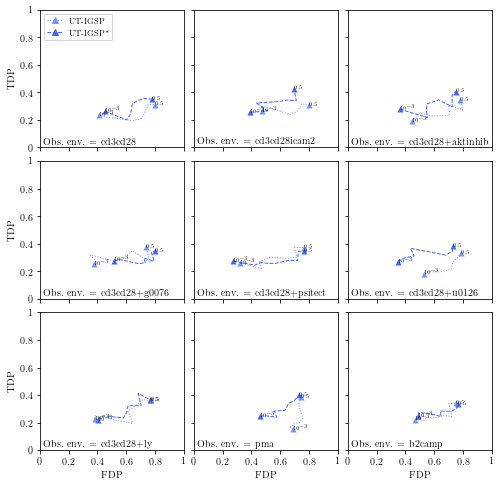

In [12]:
text = True
textsize = 5
lineopts = {'linewidth': 1}
ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
marker = {'gnies': '.',
          'gnies_rank': '.',
          'ges': '*',
          'ut_igsp': '^',
          'ut_igsp_hsic': '^',
          'jci_pc': 's',           
}
style = {'gnies': '-',
         'gnies_rank': ':',
         'ges': ':',
         'ut_igsp': ':',
         'ut_igsp_hsic': '--',
         'jci_pc': ':',
           
}
color = {'gnies': colors[0],
         'gnies_rank': colorsa[0],
         'ges': colors[1],
         'ut_igsp': colors[4],
         'ut_igsp_hsic': colors[5],
         'jci_pc': colors[2],
         
}

print_names = {'ut_igsp': 'UT-IGSP',
               'ut_igsp_hsic': 'UT-IGSP*',
               #'jci_pc': 'JCI-PC',         
}

def set_ax(ax, yticks=True, xticks=True):
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('FDP') if xticks else None
    ax.set_ylabel('TDP') if yticks else None
    ax.set_yticks(ticks)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks) if xticks else ax.set_xticklabels([])
    ax.set_yticklabels(ticks) if yticks else ax.set_yticklabels([])

def plot_metric(ax, values_x, values_y, lambdas, method, points, text, gray=False):
    c = '#aaaaaa' if gray else color[method]
    values_y = 1 - values_y
    ax.plot(values_x, values_y, color=c, linestyle=style[method], **lineopts)
    for j, l in enumerate(lambdas):
        #ax.scatter(values_x[j], values_y[j], color=color[method], marker=".", linewidth=0)
        if j==0 and text[0] is not None:
            if l <= 0.001:
                l = np.log10(l)
                fmt = "$10^{%d}$"
            else:
                fmt = "$"+text[0]+"$"
            ax.text(values_x[j], values_y[j], fmt % l, fontsize=textsize, ha="left")
        if l==lambdas[-1] and text[1] is not None:
            ax.text(values_x[j], values_y[j], ("$"+text[1]+"$") % l, fontsize=textsize, ha="left")
        if j in points:
            ax.scatter(values_x[j], values_y[j], color=c, marker=marker[method], linewidth=0)

cols = 3
d = 2.7
gs = gridspec.GridSpec(cols, cols, wspace=0.07, hspace=0.1)
plt.figure(figsize=(d*cols,d*cols))
ax = plt.gca()

for i in range(9):
    ###########################
    # PLOT REAL DATA
    plt.subplot(gs[i])
    ax = plt.gca()    
    if i == 0:
        ax0 = ax    
    # Plot UT-IGSP
    plot_metric(ax, t1e_gauss[i], t2e_gauss[i], alphas_gauss[i], 'ut_igsp', [0,len(alphas_gauss[i])-1], ["%0.2f", "%0.1f"])
    # Plot UT-IGSP*
    plot_metric(ax, t1e_hsic[i], t2e_hsic[i], alphas_hsic[i], 'ut_igsp_hsic', [0,len(alphas_hsic[i])-1], ["%0.2f", "%0.1f"])
    set_ax(ax, yticks=i % 3 == 0, xticks=i >= 6)
    ax.text(0.025,0.025,"Obs. env. = %s" % env_names[i+1])
# Build legend
method_entries = [Line2D([0], [0],
                         linewidth=1,
                         linestyle=style[method],
                         marker=marker[method],
                         color=color[method]) for method in print_names.keys()]
method_str = list(print_names.values())
ax0.legend(method_entries, #+ sample_size_entries
          method_str, # + sample_size_str
          prop={'size':8},
          loc='upper left',
        ncol=1)

filename = 'figures/figure_sachs_drf_all_obs.pdf'
plt.savefig(filename, bbox_inches='tight')

### Plot with best environment choice and other methods

**GnIES**

In [13]:
gnies_args, gnies_results_real, _, gnies_metrics_real, gnies_lambdas = load_results(directory_real, 'gnies_fb')
#gnies_args, gnies_results, _, gnies_metrics_gauss, gnies_lambdas = load_results(directory_gauss, 'gnies_fb')
gnies_args, gnies_results_drf, _, gnies_metrics_drf, gnies_lambdas = load_results(directory_drf, 'gnies_fb')

gnies_x_real = np.nanmean(gnies_metrics_real[metrics.type_1_structc], axis=(0,3))
gnies_y_real = np.nanmean(gnies_metrics_real[metrics.type_2_structc], axis=(0,3))

#gnies_x_gauss = np.nanmean(gnies_metrics_gauss[metrics.type_1_structc], axis=(0,3))
#gnies_y_gauss = np.nanmean(gnies_metrics_gauss[metrics.type_2_structc], axis=(0,3))

gnies_x_drf = np.nanmean(gnies_metrics_drf[metrics.type_1_structc], axis=(0,3))
gnies_y_drf = np.nanmean(gnies_metrics_drf[metrics.type_2_structc], axis=(0,3))

(gnies_metrics_real[metrics.success_metric].mean()
 #,gnies_metrics_gauss[metrics.success_metric].mean()
 ,gnies_metrics_drf[metrics.success_metric].mean())

(1.0, 1.0)

**UT-IGSP**

In [14]:
j = 2

In [15]:
ut_igsp_x_real, ut_igsp_y_real, ut_igsp_alphas_real = t1e_real_gauss[j], t2e_real_gauss[j], alphas_real_gauss[j]
ut_igsp_x_drf, ut_igsp_y_drf, ut_igsp_alphas_drf = t1e_drf_gauss[j], t2e_drf_gauss[j], alphas_drf_gauss[j]

**UT-IGSP***

In [16]:
ut_igsp_hsic_x_real, ut_igsp_hsic_y_real, ut_igsp_hsic_alphas_real = t1e_real_hsic[j], t2e_real_hsic[j], alphas_real_hsic[j]
ut_igsp_hsic_x_drf, ut_igsp_hsic_y_drf, ut_igsp_hsic_alphas_drf = t1e_drf_hsic[j], t2e_drf_hsic[j], alphas_drf_hsic[j]

**GES**

In [17]:
ges_args, ges_results_real, _, ges_metrics_real, ges_lambdas = load_results(directory_real, 'ges')
#ges_args, ges_results, _, ges_metrics_gauss, ges_lambdas = load_results(directory_gauss, 'ges')
ges_args, ges_results_drf, _, ges_metrics_drf, ges_lambdas = load_results(directory_drf, 'ges')

ges_x_real = np.nanmean(ges_metrics_real[metrics.type_1_structc], axis=(0,3))
ges_y_real = np.nanmean(ges_metrics_real[metrics.type_2_structc], axis=(0,3))

#ges_x_gauss = np.nanmean(ges_metrics_gauss[metrics.type_1_structc], axis=(0,3))
#ges_y_gauss = np.nanmean(ges_metrics_gauss[metrics.type_2_structc], axis=(0,3))

ges_x_drf = np.nanmean(ges_metrics_drf[metrics.type_1_structc], axis=(0,3))
ges_y_drf = np.nanmean(ges_metrics_drf[metrics.type_2_structc], axis=(0,3))

(ges_metrics_real[metrics.success_metric].mean()
# ,ges_metrics_gauss[metrics.success_metric].mean()
 ,ges_metrics_drf[metrics.success_metric].mean())

(1.0, 1.0)

In [18]:
ges_x_real

array([[0.91489362],
       [0.80555556],
       [0.82352941],
       [0.81818182],
       [0.83870968],
       [0.84615385]])

## Figure 3 (sachs dataset in main text)

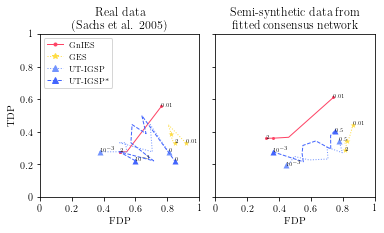

In [19]:
plot_gauss = False
text = True
textsize = 5
lineopts = {'linewidth': 1}
ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
marker = {'gnies': '.',
          'gnies_rank': '.',
          'ges': '*',
          'ut_igsp': '^',
          'ut_igsp_hsic': '^',
          'jci_pc': 's',           
}
style = {'gnies': '-',
         'gnies_rank': ':',
         'ges': ':',
         'ut_igsp': ':',
         'ut_igsp_hsic': '--',
         'jci_pc': ':',
           
}
color = {'gnies': colors[0],
         'gnies_rank': colorsa[0],
         'ges': colors[1],
         'ut_igsp': colors[4],
         'ut_igsp_hsic': colors[5],
         'jci_pc': colors[2],
         
}

print_names = {'gnies': 'GnIES',
               #'gnies_rank': 'GnIES-rank',
               'ges': 'GES',
               'ut_igsp': 'UT-IGSP',
               'ut_igsp_hsic': 'UT-IGSP*',
               #'jci_pc': 'JCI-PC',         
}

def set_ax(ax, yticks=True):
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('FDP')
    ax.set_ylabel('TDP') if yticks else None
    ax.set_yticks(ticks)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_yticklabels(ticks) if yticks else ax.set_yticklabels([])

def plot_metric(ax, values_x, values_y, lambdas, method, points, text, gray=False):
    c = '#aaaaaa' if gray else color[method]
    values_y = 1 - values_y
    ax.plot(values_x, values_y, color=c, linestyle=style[method], **lineopts)
    for j, l in enumerate(lambdas):
        #ax.scatter(values_x[j], values_y[j], color=color[method], marker=".", linewidth=0)
        if j==0 and text[0] is not None:
            if l <= 0.001:
                l = np.log10(l)
                fmt = "$10^{%d}$"
            else:
                fmt = "$"+text[0]+"$"
            ax.text(values_x[j], values_y[j], fmt % l, fontsize=textsize, ha="left")
        if l==lambdas[-1] and text[1] is not None:
            ax.text(values_x[j], values_y[j], ("$"+text[1]+"$") % l, fontsize=textsize, ha="left")
        if j in points:
            ax.scatter(values_x[j], values_y[j], color=c, marker=marker[method], linewidth=0)

cols = 3 if plot_gauss else 2
gs = gridspec.GridSpec(1, cols, wspace=0.10, hspace=0.2)
plt.figure(figsize=(3*cols,3))
ax = plt.gca()

###########################
# PLOT REAL DATA
plt.subplot(gs[0])
ax = plt.gca()    
ax0 = ax
# Plot GnIES
plot_metric(ax, gnies_x_real, gnies_y_real, gnies_lambdas, 'gnies', [0,2,len(gnies_lambdas)-1], ["%0.2f", "%d"])      
# Plot UT-IGSP
plot_metric(ax, ut_igsp_x_real, ut_igsp_y_real, ut_igsp_alphas_real, 'ut_igsp', [0,len(ut_igsp_alphas_real)-1], ["%0.2f", "%d"])
# Plot UT-IGSP*
plot_metric(ax, ut_igsp_hsic_x_real, ut_igsp_hsic_y_real, ut_igsp_hsic_alphas_real, 'ut_igsp_hsic', [0,len(ut_igsp_hsic_alphas_real)-1], ["%0.2f", "%d"])
# Plot GES
plot_metric(ax, ges_x_real, ges_y_real, ges_lambdas, 'ges', [0,2,len(ges_lambdas)-1], ["%0.2f", "%d"])    
set_ax(ax, yticks=True)
ax.set_title("Real data\n(Sachs et al. 2005)")

###########################
# PLOT GAUSSIAN DATA
if plot_gauss:
    plt.subplot(gs[1])
    ax = plt.gca()    
    # Plot GnIES
    plot_metric(ax, gnies_x_gauss, gnies_y_gauss, gnies_lambdas, 'gnies', [0,2,len(gnies_lambdas)-1], ["%0.2f", "%d"])      
    # Plot UT-IGSP
    plot_metric(ax, ut_igsp_x_gauss, ut_igsp_y_gauss, ut_igsp_alphas_gauss, 'ut_igsp', [0,len(ut_igsp_alphas_gauss)-1], ["%0.2f", "%0.1f"])
    # Plot UT-IGSP*
    plot_metric(ax, ut_igsp_hsic_x_gauss, ut_igsp_hsic_y_gauss, ut_igsp_hsic_alphas_gauss, 'ut_igsp_hsic', [0,len(ut_igsp_hsic_alphas_gauss)-1], ["%0.2f", "%0.1f"])
    # Plot GES
    plot_metric(ax, ges_x_gauss, ges_y_gauss, ges_lambdas, 'ges', [0,2,len(ges_lambdas)-1], ["%0.2f", "%d"])    
    set_ax(ax, yticks=False)
    ax.set_title("Data from fitted Gaussian SCM")

###########################
# PLOT DRF DATA
plt.subplot(gs[2 if plot_gauss else 1])
ax = plt.gca()    
# Plot GnIES
plot_metric(ax, gnies_x_drf, gnies_y_drf, gnies_lambdas, 'gnies', [0,2,len(gnies_lambdas)-1], ["%0.2f", "%d"])      
# Plot UT-IGSP
plot_metric(ax, ut_igsp_x_drf, ut_igsp_y_drf, ut_igsp_alphas_drf, 'ut_igsp', [0,len(ut_igsp_alphas_drf)-1], ["%0.2f", "%0.1f"])
# Plot UT-IGSP*
plot_metric(ax, ut_igsp_hsic_x_drf, ut_igsp_hsic_y_drf, ut_igsp_hsic_alphas_drf, 'ut_igsp_hsic', [0,len(ut_igsp_hsic_alphas_drf)-1], ["%0.2f", "%0.1f"])
# Plot GES
plot_metric(ax, ges_x_drf, ges_y_drf, ges_lambdas, 'ges', [0,2,len(ges_lambdas)-1], ["%0.2f", "%d"])    
set_ax(ax, yticks=False)
#ax.set_title("Data from fitted DRF SCM")
ax.set_title("Semi-synthetic data with consensus\nnetwork as ground truth")
ax.set_title("Semi-synthetic data from\nfitted consensus network")
#ax.set_title("Semi-synthetic data\n(ground truth=consensus network)")

# Build legend
method_entries = [Line2D([0], [0],
                         linewidth=1,
                         linestyle=style[method],
                         marker=marker[method],
                         color=color[method]) for method in print_names.keys()]
method_str = list(print_names.values())
ax0.legend(method_entries, #+ sample_size_entries
          method_str, # + sample_size_str
          prop={'size':8},
          loc='upper left',
        ncol=1)

filename = 'figures/figure_sachs_both.pdf'
plt.savefig(filename, bbox_inches='tight')

## Figures 4 and 5 (real vs. semi-synthetic data)

In [20]:
import sachs

In [59]:
def plot_marginals_large(datas, labels, colors, edgecolors, hatches, filename=None):
    node2idx = dict((n,i) for i,n in enumerate(sachs.node_names))    
    gs = gridspec.GridSpec(4, 3, wspace=0.2, hspace=0.2)
    for name,i in node2idx.items():
        plt.subplot(gs[i+1])        
        ax = plt.gca()
        if i==0:
            ax0 = ax
        ax.text(0.9,0.9,"%s" % name, transform=ax.transAxes, fontsize=12, ha='right', va='top')
        hist = ax.hist([data[:,i] for data in datas])    
        for i,bars in enumerate(hist[2]):
            for j,bar in enumerate(bars):
                bar.set(fill=True, hatch=hatches[i], linewidth=1, facecolor=colors[i], edgecolor=edgecolors[i])
                bar.set(label=labels[i]) if j==0 else None    
    ax0.legend(loc=(-1.2,0.5), prop={'size': 12})
    
def plot_marginals_small(datas, labels, colors, edgecolors, hatches, filename=None):
    node2idx = dict((n,i) for i,n in enumerate(sachs.node_names))    
    gs = gridspec.GridSpec(2, 6, wspace=0.05, hspace=0.05)
    for name,i in node2idx.items():
        plt.subplot(gs[i+1])
        ax = plt.gca()
        if i==0:
            ax0 = ax
        ax.text(0.9,0.9,"%s" % name, transform=ax.transAxes, fontsize=12, ha='right', va='top')
        hist = ax.hist([data[:,i] for data in datas])    
        for i,bars in enumerate(hist[2]):
            for j,bar in enumerate(bars):
                bar.set(fill=True, hatch=hatches[i], linewidth=1, facecolor=colors[i], edgecolor=edgecolors[i])
                bar.set(label=labels[i]) if j==0 else None    
        ax.set_xticks([])
        ax.set_yticks([])
    ax0.legend(loc=(-1.4,0.5), prop={'size': 10})

In [60]:
real_data = utils.load_bin(directory_real + "test_case_n:-1_g:0_r:0")
drf_data = utils.load_bin(directory_drf + "test_case_n:-1_g:0_r:0")

In [61]:
node2idx = dict((n,i) for i,n in enumerate(sachs.node_names))
node2idx['PKA'], node2idx['PKC']

(8, 6)

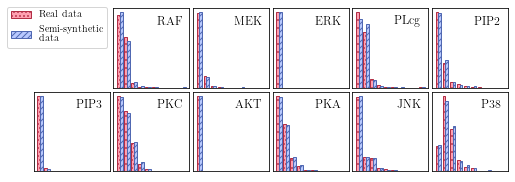

In [62]:
labels = ['Real data', 'Semi-synthetic\ndata']
plt.figure(figsize=(8.5,3))
gs = plot_marginals_small([real_data[0], drf_data[0]], labels=labels, colors=colorsa[[0,4]], edgecolors=colorsb[[0,4]], hatches=['...', '////'])
plt.savefig("figures/real_vs_drf_marginals_flat.pdf", bbox_inches='tight',transform=ax.transAxes)

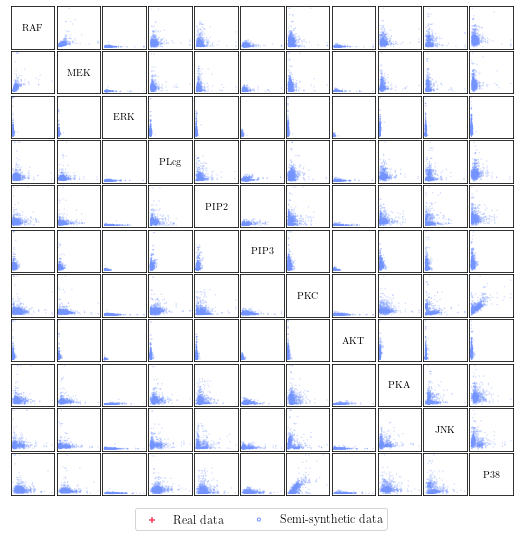

In [40]:
k=0
p = len(node2idx)
delta = 1
plt.figure(figsize=(9*delta,9*delta))
gs = gridspec.GridSpec(p, p, wspace=0.05, hspace=0.05)
idx2node = dict((i,n) for i,n in enumerate(sachs.node_names))
for x in range(p):
    for y in range(p):
        plt.subplot(gs[x,y])
        ax = plt.gca()
        size = 0.1
        if x==y:
            ax.text(0.5,0.5,idx2node[x], ha="center", va="center", )
        elif x > y:
            ax.scatter(real_data[k][:,x], real_data[k][:,y], s=size, marker='+', color=colors[0], label=labels[0])
            ax.scatter(drf_data[k][:,x], drf_data[k][:,y], s=size, marker='.', facecolor="",color=colors[4], label=labels[1])
        else:            
            ax.scatter(drf_data[k][:,x], drf_data[k][:,y], s=size, marker='.', facecolor="", color=colors[4], label=labels[1])
            ax.scatter(real_data[k][:,x], real_data[k][:,y], s=size, marker='+', color=colors[0], label=labels[0])
        ax.set_xticks([])
        ax.set_yticks([])
        # Legend
        if x == p - 1 and y == 0:            
            ax.legend(ncol=2, bbox_to_anchor=(8.75, -.15), markerscale=20, prop={'size': 12})
#plt.savefig("figures/all_marginals_sachs.pdf", bbox_inches="tight")
plt.savefig("figures/all_marginals_sachs.png", dpi=300, bbox_inches="tight")
plt.savefig("figures/all_marginals_sachs_talk.png", dpi=600, bbox_inches="tight")

In [ ]:
k = 0
node2idx = dict((n,i) for i,n in enumerate(sachs.node_names))
x_node, y_node = 'ERK', 'AKT'
#x_node, y_node = 'PIP3', 'PLcg'
#x_node, y_node = 'PLcg', 'PIP2'
#x_node, y_node = 'PKC', 'RAF'
x,y = node2idx[x_node], node2idx[y_node]
plt.figure(figsize=(5,5))
ax = plt.gca()
t = lambda x: x
ax.set_xlim([-1,7])
ax.set_ylim([-1,5])
ax.scatter(real_data[k][:,x], t(real_data[k][:,y]), marker='+', color=colors[0], label=labels[0])
ax.scatter(drf_data[k][:,x], t(drf_data[k][:,y]), marker='.', facecolor="", color=colors[4], label=labels[1])
ax.set_xlabel(x_node)
ax.set_ylabel(y_node)
#ax.text(0.8,0.6, "%s $\\to$ %s" % (x_node, y_node), transform=ax.transAxes, ha='right', va='top', size=12)
#ax.legend(title="%s $\\to$ %s" % (x_node, y_node))
plt.savefig("figures/%s_vs_%s.pdf" % (x_node, y_node),bbox_inches='tight')
plt.savefig("figures/%s_vs_%s.png" % (x_node, y_node),bbox_inches='tight',dpi=600)

In [ ]:
k = 0
node2idx = dict((n,i) for i,n in enumerate(sachs.node_names))
x_node, y_node = 'ERK', 'AKT'
#x_node, y_node = 'PIP3', 'PLcg'
#x_node, y_node = 'PLcg', 'PIP2'
#x_node, y_node = 'PKC', 'RAF'
x,y = node2idx[x_node], node2idx[y_node]
plt.figure(figsize=(5,5))
ax = plt.gca()
t = lambda x: x
ax.set_xlim([-1,7])
ax.set_ylim([-1,5])
ax.scatter(real_data[k][:,x], t(real_data[k][:,y]), marker='+', color=colors[0], label=labels[0])
ax.set_xlabel(x_node)
ax.set_ylabel(y_node)
#ax.text(0.8,0.6, "%s $\\to$ %s" % (x_node, y_node), transform=ax.transAxes, ha='right', va='top', size=12)
#ax.legend(title="%s $\\to$ %s" % (x_node, y_node))
plt.savefig("figures/%s_vs_%s_real.pdf" % (x_node, y_node),bbox_inches='tight')
plt.savefig("figures/%s_vs_%s_real.png" % (x_node, y_node),bbox_inches='tight',dpi=600)

## Talk figures (real vs. semi-synthetic data)

import sachs

colors = ["gray", "#82dbac"]
# colors = ["#ff4365", "#82dbac"]
edgecolors = ["#2a2a2a", "#5cbb88"]#"#6ac997"]
#darkred = [0.69726562, 0.18320312, 0.27617187, 1.        ]
#edgecolors = [darkred, "#5cbb88"]#"#6ac997"]

real_data = utils.load_bin(directory_real + "test_case_n:-1_g:0_r:0")
drf_data = utils.load_bin(directory_drf + "test_case_n:-1_g:0_r:0")

node2idx = dict((n,i) for i,n in enumerate(sachs.node_names))
node2idx['PKA'], node2idx['PKC']

labels = ['Real data', 'Semi-synthetic data']
plt.figure(figsize=(9,12))
gs = plot_marginals([real_data[0], drf_data[0]], labels=labels, colors=colors, edgecolors=edgecolors, hatches=['...', '////'])
plt.savefig("figures/real_vs_drf_marginals_talk.png", bbox_inches='tight',transform=ax.transAxes, dpi=350)

k=0
p = len(node2idx)
delta = 1
plt.figure(figsize=(9*delta,9*delta))
gs = gridspec.GridSpec(p, p, wspace=0.05, hspace=0.05)
idx2node = dict((i,n) for i,n in enumerate(sachs.node_names))
for x in range(p):
    for y in range(p):
        plt.subplot(gs[x,y])
        ax = plt.gca()
        size = 0.5
        if x==y:
            ax.text(0.5,0.5,idx2node[x], ha="center", va="center", )
        elif x > y:
            ax.scatter(real_data[k][:,x], real_data[k][:,y], s=size, marker='+', color=edgecolors[0], label=labels[0])
            ax.scatter(drf_data[k][:,x], drf_data[k][:,y], s=size, marker='.', color=edgecolors[1], label=labels[1])
        else:            
            ax.scatter(drf_data[k][:,x], drf_data[k][:,y], s=size, marker='.', color=edgecolors[1], label=labels[1])
            ax.scatter(real_data[k][:,x], real_data[k][:,y], s=size, marker='+', color=edgecolors[0], label=labels[0])
        ax.set_xticks([])
        ax.set_yticks([])
        # Legend
        if x == p - 1 and y == 0:            
            ax.legend(ncol=2, bbox_to_anchor=(8.75, -.15), markerscale=20, prop={'size': 12})
#plt.savefig("figures/all_marginals_sachs.pdf", bbox_inches="tight")
#plt.savefig("figures/all_marginals_sachs_talk.png", dpi=600, bbox_inches="tight")

k = 0
node2idx = dict((n,i) for i,n in enumerate(sachs.node_names))
x_node, y_node = 'ERK', 'AKT'
#x_node, y_node = 'PIP3', 'PLcg'
#x_node, y_node = 'PLcg', 'PIP2'
#x_node, y_node = 'PKC', 'RAF'
x,y = node2idx[x_node], node2idx[y_node]
plt.figure(figsize=(5,5))
ax = plt.gca()
t = lambda x: x
ax.set_xlim([-1,7])
ax.set_ylim([-1,5])
ax.scatter(real_data[k][:,x], t(real_data[k][:,y]), marker='+', color=edgecolors[0], label=labels[0])
ax.scatter(drf_data[k][:,x], t(drf_data[k][:,y]), marker='.', color=edgecolors[1], label=labels[1])
ax.set_xlabel(x_node)
ax.set_ylabel(y_node)
#ax.text(0.8,0.6, "%s $\\to$ %s" % (x_node, y_node), transform=ax.transAxes, ha='right', va='top', size=12)
#ax.legend(title="%s $\\to$ %s" % (x_node, y_node))
plt.savefig("figures/%s_vs_%s.pdf" % (x_node, y_node),bbox_inches='tight')
plt.savefig("figures/%s_vs_%s.png" % (x_node, y_node),bbox_inches='tight',dpi=600)